Move stuff in here into plotting, so that code in this notebook is focused on test only

In [ ]:
%load_ext autoreload
%autoreload 2
import data_extraction.get_indices as get_indices
import parse_data.prepare_data as prepare_data
import globals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotting import plot_octagon, plot_trajectory
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall
import data_strings
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import analysis.wall_choice as wall_choice
import data_extraction.extract_trial as extract_trial


In [2]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [3]:
json_filename = json_filenames_all_social[3]

In [4]:
_, trial_list = prepare_data.prepare_data(data_folder, json_filename, combine=True)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.


In [5]:
wall_sep = None
trial_type = globals.HIGH_LOW

In [6]:
# # filtered version of the trial list
# filter trial list for given_wallLow trialtype
trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
trial_list_filtered = [trial_list[i] for i in trial_indices]

# filter trial list for wall separations if specified
if wall_sep:
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=wall_sep)
    trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


In [7]:
trial_num = 15
player_id = 1
trial = trial_list[trial_num]

In [8]:
# gather data for head angle and wall vector plots

# trajectory and headangle vectors for the trial 
trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
trial_player_headangles =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles)
trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

# vectors between player and alcove, for all walls and timepoints
player_to_alcove_vectors = trajectory_vectors.get_player_to_alcove_direction_vectors_for_trajectory(trajectory,
                                                                                     num_walls=8)
# get either the clockwise or counterclockwise octagon vertex coordinate, depending on whether the wall is CW or CCW of the current
# player head direction
wall_coords_cross_product_dependent = trajectory_headangle.get_wall_coords_cross_product_dependent(trial=trial, player_id=player_id)
# using the above coordinates, get the vectors for each wall between head direction and CW or CCW wall coordinate
player_to_closest_wall_section = trajectory_headangle.get_player_to_closest_wall_section_direction_vectors_for_trajectory(trajectory,
                                                                                              wall_coords_cross_product_dependent)

# find angles between the head direction and the closest wall sections for each timepoint in the trajectory
thetas_closest_wall_section = trajectory_headangle.head_angle_to_closest_wall_section_throughout_trajectory(trial=trial,
                                                                  player_id=player_id)
thetas_closest_wall_section = np.rad2deg(thetas_closest_wall_section)

# find the angles between the head direction and the alcove centre for each timepoint in the trajectory
thetas_trajectory = trajectory_headangle.head_angle_to_walls_throughout_trajectory(trajectory,
                                                                                   headangles,
                                                                                   window_size=10, num_walls=8)
thetas_trajectory = np.rad2deg(thetas_trajectory)


In [9]:
# gather data for the first visible wall for the session
(condition_fulfilled_session,
  player_chose_given_wall_session) = wall_visibility_and_choice.given_wall_chosen_conditioned_on_visibility(trial_list, player_id,
                                                                                                            given_wall_index=0, given_wall_first_vis=True,
                                                                                                              current_fov=110, wall_sep=None, trial_type=globals.HIGH_LOW,
                                                                                                                inferred_choice=False, debug=False)


player_wall_choice = wall_choice.player_wall_choice_wins_only(trial_list_filtered, player_id)


 player wall choice this trial: 5.0
 this_player_this_trial_first_visible_wall_chosen: True
for trial 0, trial_player_chose_given_wall added to array as True
 player wall choice this trial: nan
not confident in loser's choice, or inferred choice not used
 first_vis_wall_chosen: nan
 this_player_this_trial_first_visible_wall_chosen: nan
for trial 1, trial_player_chose_given_wall added to array as nan
 player wall choice this trial: 3.0
 this_player_this_trial_first_visible_wall_chosen: True
for trial 2, trial_player_chose_given_wall added to array as True
 player wall choice this trial: nan
not confident in loser's choice, or inferred choice not used
 first_vis_wall_chosen: nan
 this_player_this_trial_first_visible_wall_chosen: nan
for trial 3, trial_player_chose_given_wall added to array as nan
 player wall choice this trial: nan
not confident in loser's choice, or inferred choice not used
 first_vis_wall_chosen: nan
 this_player_this_trial_first_visible_wall_chosen: nan
for trial 4, t

In [10]:
np.sum(~np.isnan(player_chose_given_wall_session))

np.int64(92)

In [11]:
player_wall_choice.size, np.sum(~np.isnan(player_wall_choice))

(136, np.int64(92))

In [42]:
def get_visualisation_vector_coordinates(trial_list, trial_num, trajectory, trial_player_headangles_smoothed, player_to_alcove_vectors,
                                     player_to_closest_wall_section, start_index=0, vector_length=20,
                                     wall_index=None):
    ''' Return the coordinates of the vectors that originate at the player location and project towards
        the direction of headangle, the wall alcove, and the wall closest-wall-section.
        Input is the trial list, trajectory, smoothed player headangles, player-to-alcove vectors,
        and player-to-closest-wall-section vectors for the trial.
        Optional arguments specify the point in the trajectory to take as the origin, the vector length,
        and the wall to use as the wall_idex (default, real chosen wall for this trial).'''


    start_index=start_index
    if not wall_index:
        wall_index = int(get_indices.get_chosen_walls(trial_list)[trial_num] - 1)
    
    # get the start coordinates for the vector as the location of the player at the specified point
    # in the trajectory
    x_start = trajectory[0,start_index]
    y_start = trajectory[1,start_index]

    # calculate gradients for the vectors of: current headangle, player-to-alcove (given wall index)
    # and player-to-closest-wall-section (given wall index)
    x_gradient = trial_player_headangles_smoothed[0,start_index]
    y_gradient = trial_player_headangles_smoothed[1,start_index]
    x_gradient_alcove = player_to_alcove_vectors[0,wall_index,start_index]
    y_gradient_alcove = player_to_alcove_vectors[1,wall_index,start_index]
    x_gradient_closest_wall_section = player_to_closest_wall_section[0,wall_index,start_index]
    y_gradient_closest_wall_section = player_to_closest_wall_section[1,wall_index,start_index] 

    vector_length = vector_length

    # assign coordinate values to the start and end point for each vector
    start = [x_start, y_start]
    end_head_direction = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    end_wall_alcove = [x_start + x_gradient_alcove, y_start + y_gradient_alcove]
    end_wall_section = [x_start + x_gradient_closest_wall_section, y_start + y_gradient_closest_wall_section]

    # zip start and end values and return as arrays
    head_direction_vector_coordinates = np.array(list(zip(start,end_head_direction)))
    alcove_direction_vector_coordinates = np.array(list(zip(start,end_wall_alcove)))
    closest_wall_section_vector_coordinates = np.array(list(zip(start,end_wall_section)))

    return (head_direction_vector_coordinates, alcove_direction_vector_coordinates,
             closest_wall_section_vector_coordinates, wall_index)

In [52]:
def plot_octagon_visualisation_vectors(head_direction_vector_coordinates, alcove_direction_vector_coordinates,
                                        closest_wall_section_vector_coordinates, wall_index, start_index=0,
                                        colours = ['r','g','orange'], axes=None):
    ''' Return plotted axes of octagon with the visualisation vectors for head angle, player-to-alcove, and 
        player-to-closest-wall-section for the given wall index and trajectory start index.
        Takes the start and end coordinates of these vectors, and the wall index (see 
        get_visualisation_vector_coordinates for details).'''
    
    # plot visualisation vectors over octagon base, head direction alcove direction and closest wall section
    # colours are decided by the colours array parameter
    colours= colours
    ax = plot_octagon.plot_octagon(ax=axes)
    ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)
    ax.plot(head_direction_vector_coordinates[0,:], head_direction_vector_coordinates[1,:], c=colours[0], linewidth=2)
    ax.plot(alcove_direction_vector_coordinates[0,:], alcove_direction_vector_coordinates[1,:], c=colours[1], linewidth=2)
    ax.plot(closest_wall_section_vector_coordinates[0,:], closest_wall_section_vector_coordinates[1,:], c=colours[2], linewidth=2)

    # change plot params
    for spine in ax.spines.values():
        spine.set_visible(False)
        ax.tick_params(left=False, bottom=False)  # Turn off major ticks
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    return ax

In [19]:
def get_angles_between_head_and_wall_locations(thetas_trajectory, wall_index, start_index=0):
    ''' Return the angles between the head direction and wall alcove centre, and head direction 
        and closest wall section'''

    # print the angle between head direction and wall_index, and closest_wall_section
    print(thetas_trajectory[wall_index,start_index], thetas_closest_wall_section[wall_index,start_index])

    return thetas_trajectory[wall_index,start_index], thetas_closest_wall_section[wall_index,start_index]

In [35]:
def get_trajectory_related_information(trial=None, trial_list=None, trial_index=None, player_id=0):
    '''gather data for head angle and wall vector plots''' 

    # get trial
    trial = plot_trajectory.extract_trial(trial, trial_list, trial_index)

    # trajectory and headangle vectors for the trial 
    trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
    headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
    trial_player_headangles =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles)
    trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

    # vectors between player and alcove, for all walls and timepoints
    player_to_alcove_vectors = trajectory_vectors.get_player_to_alcove_direction_vectors_for_trajectory(trajectory,
                                                                                        num_walls=8)
    # get either the clockwise or counterclockwise octagon vertex coordinate, depending on whether the wall is CW or CCW of the current
    # player head direction
    wall_coords_cross_product_dependent = trajectory_headangle.get_wall_coords_cross_product_dependent(trial=trial, player_id=player_id)
    # using the above coordinates, get the vectors for each wall between head direction and CW or CCW wall coordinate
    player_to_closest_wall_section = trajectory_headangle.get_player_to_closest_wall_section_direction_vectors_for_trajectory(trajectory,
                                                                                                wall_coords_cross_product_dependent)

    # find angles between the head direction and the closest wall sections for each timepoint in the trajectory
    thetas_closest_wall_section = trajectory_headangle.head_angle_to_closest_wall_section_throughout_trajectory(trial=trial,
                                                                    player_id=player_id)
    thetas_closest_wall_section = np.rad2deg(thetas_closest_wall_section)

    # find the angles between the head direction and the alcove centre for each timepoint in the trajectory
    thetas_trajectory = trajectory_headangle.head_angle_to_walls_throughout_trajectory(trajectory,
                                                                                    headangles,
                                                                                    window_size=10, num_walls=8)
    thetas_trajectory = np.rad2deg(thetas_trajectory)

    return (trajectory, trial_player_headangles_smoothed, player_to_alcove_vectors, player_to_closest_wall_section,
            thetas_closest_wall_section, thetas_trajectory)

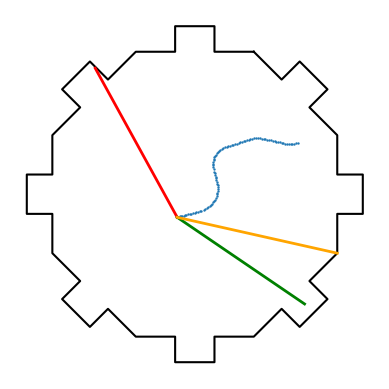

In [50]:
(head_direction_vector_coordinates,
 alcove_direction_vector_coordinates,
 closest_wall_section_vector_coordinates,
 wall_index) = get_visualisation_vector_coordinates(trial_list, trial_num, trajectory,
                                                    trial_player_headangles_smoothed,
                                                    player_to_alcove_vectors,
                                                    player_to_closest_wall_section)

ax = plot_octagon_visualisation_vectors(head_direction_vector_coordinates, alcove_direction_vector_coordinates,
                                        closest_wall_section_vector_coordinates, wall_index)

11.774228838374412 35.91022266913259


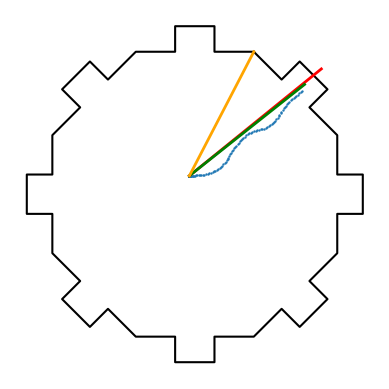

In [12]:
# example plotting head angle direction vector
start_index=0
# wall_index = 4
wall_index = int(get_indices.get_chosen_walls(trial_list)[trial_num] - 1)
x_start = trajectory[0,start_index]
y_start = trajectory[1,start_index]
x_gradient = trial_player_headangles_smoothed[0,start_index]
y_gradient = trial_player_headangles_smoothed[1,start_index]
x_gradient_alcove = player_to_alcove_vectors[0,wall_index,start_index]
y_gradient_alcove = player_to_alcove_vectors[1,wall_index,start_index]
x_gradient_closest_wall_section = player_to_closest_wall_section[0,wall_index,start_index]
y_gradient_closest_wall_section = player_to_closest_wall_section[1,wall_index,start_index] 

vector_length = 20

start = [x_start, y_start]
end_head_direction = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
end_wall_alcove = [x_start + x_gradient_alcove, y_start + y_gradient_alcove]
end_wall_section = [x_start + x_gradient_closest_wall_section, y_start + y_gradient_closest_wall_section]

head_direction_vector_coordinates = np.array(list(zip(start,end_head_direction)))
alcove_direction_vector_coordinates = np.array(list(zip(start,end_wall_alcove)))
closest_wall_section_vector_coordinates = np.array(list(zip(start,end_wall_section)))

ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)
ax.plot(head_direction_vector_coordinates[0,:], head_direction_vector_coordinates[1,:], c='r', linewidth=2)
ax.plot(alcove_direction_vector_coordinates[0,:], alcove_direction_vector_coordinates[1,:], c='g', linewidth=2)
ax.plot(closest_wall_section_vector_coordinates[0,:], closest_wall_section_vector_coordinates[1,:], c='orange', linewidth=2)

print(thetas_trajectory[wall_index,start_index], thetas_closest_wall_section[wall_index,start_index])

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

In [54]:
rows = 12
cols = 12

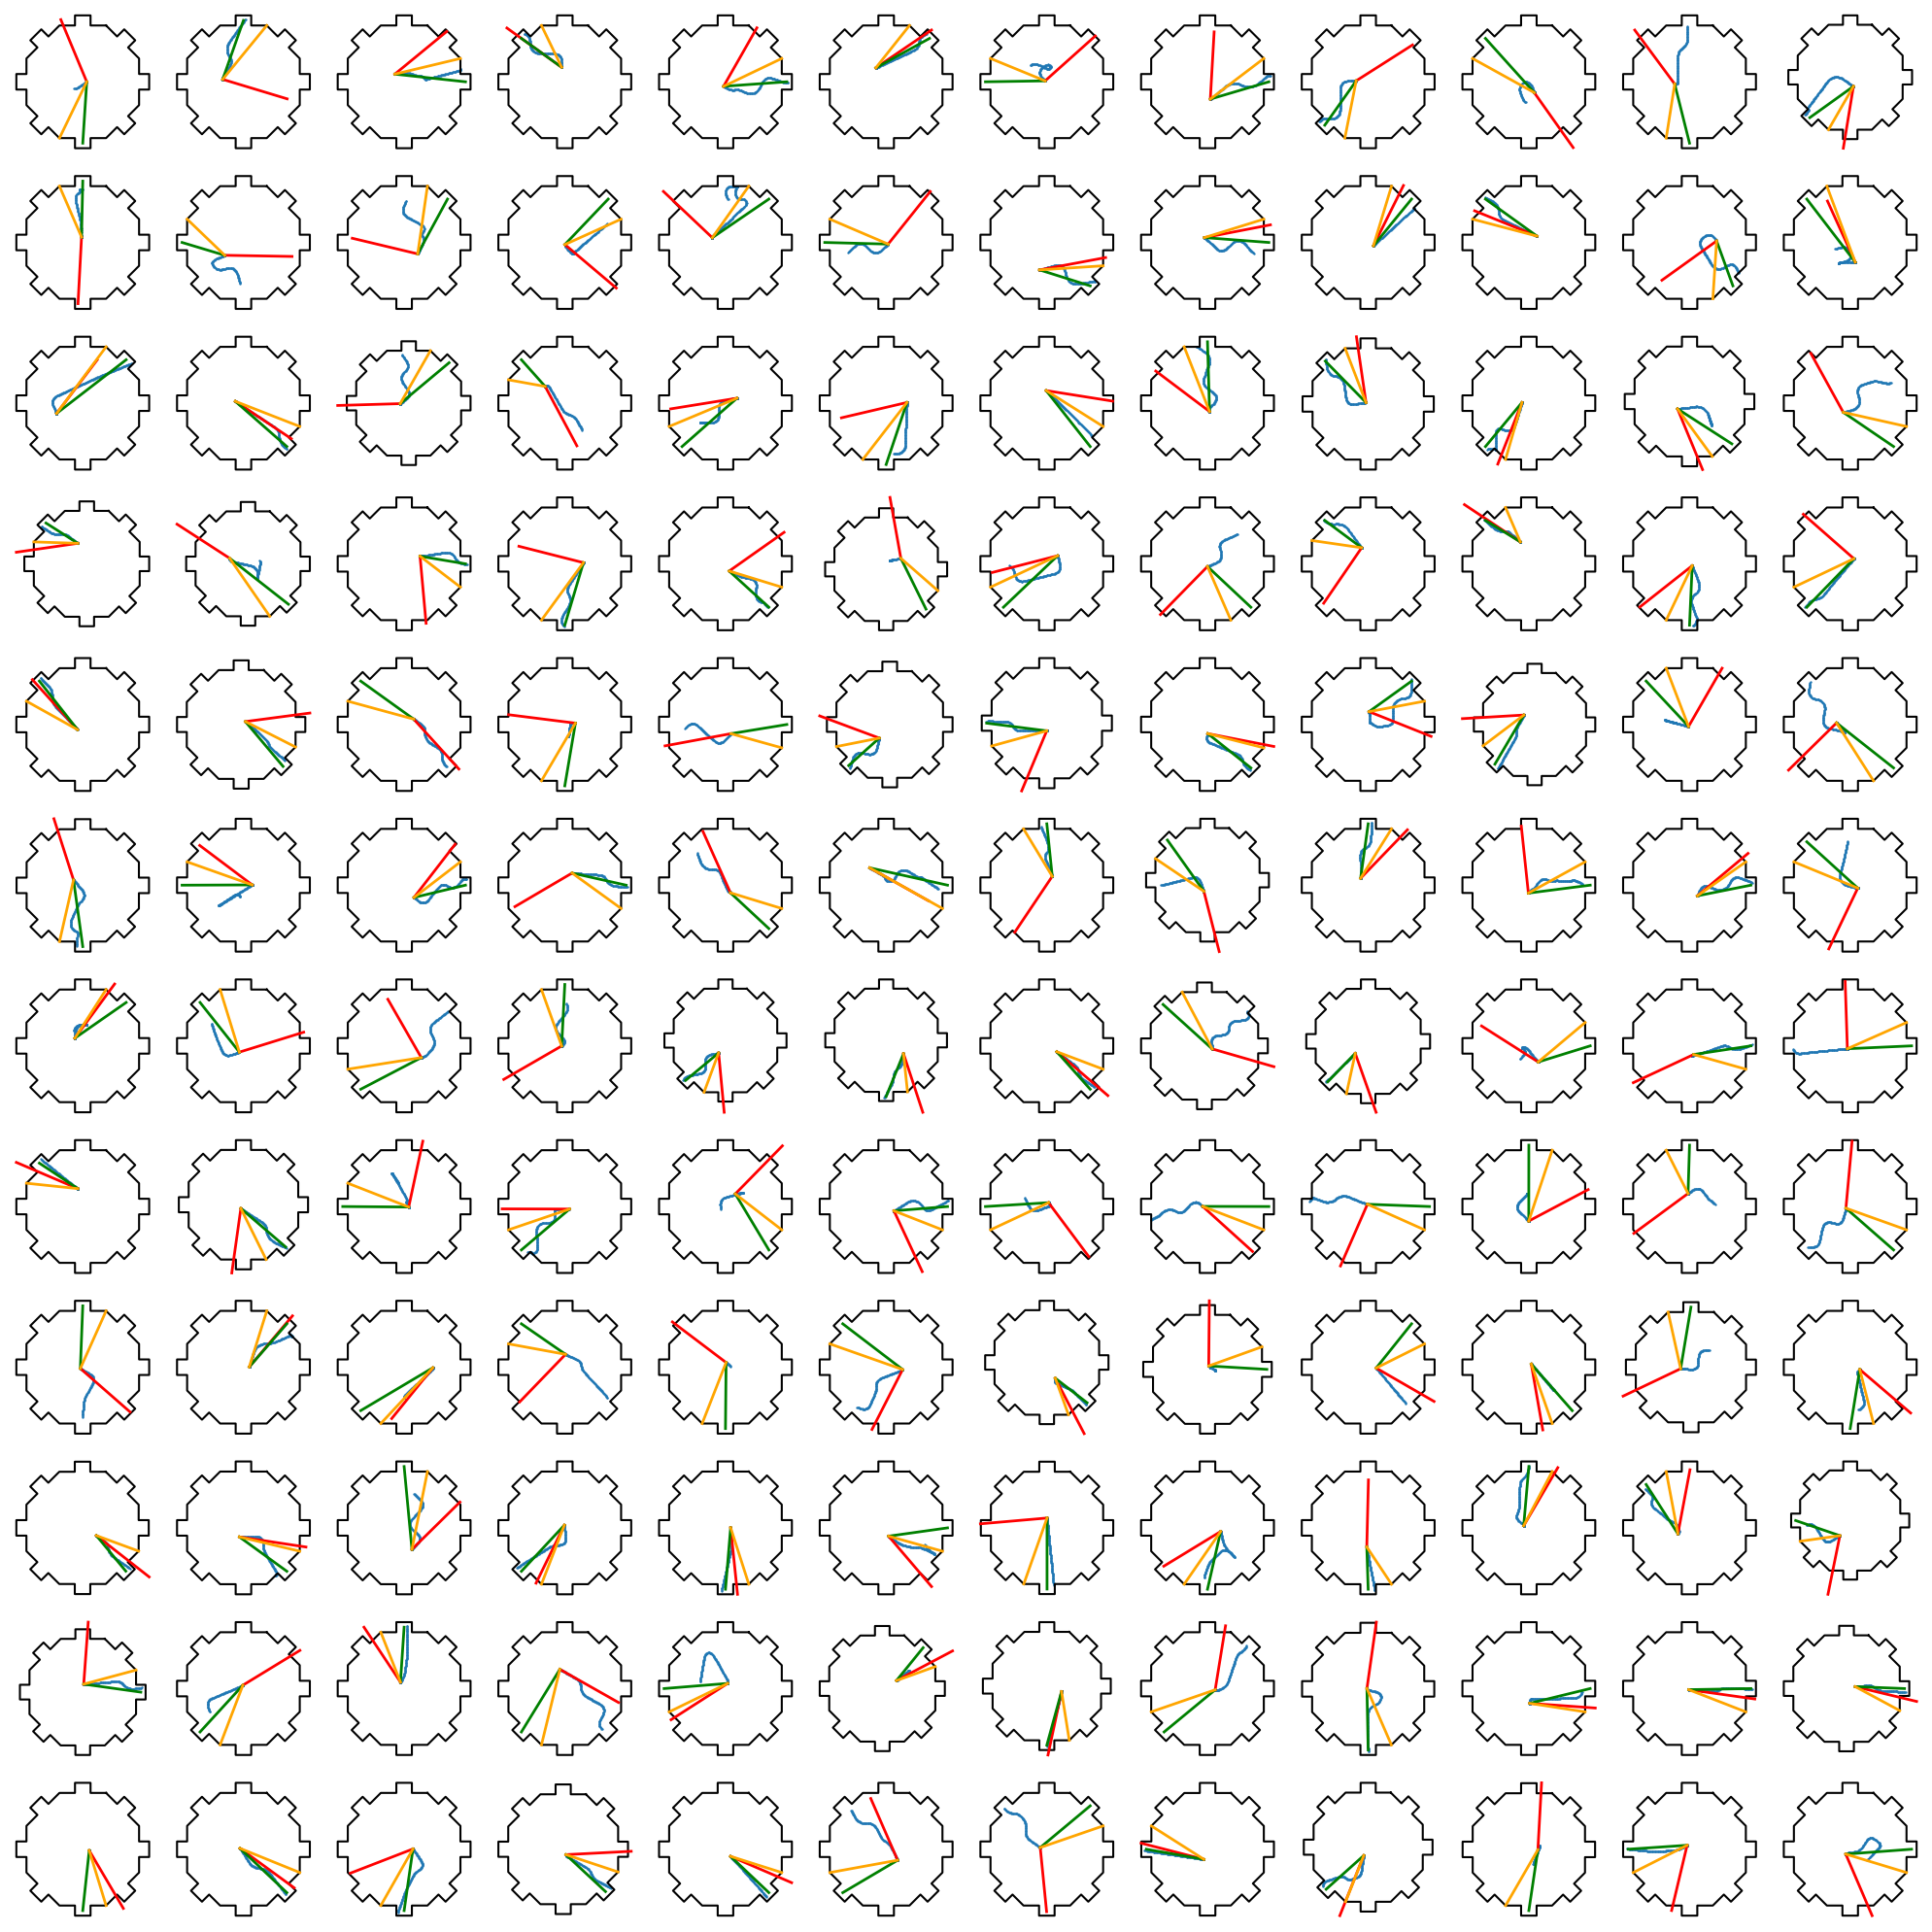

In [56]:
fig, axes = plt.subplots(rows,cols, figsize=(20,20))

# loop through each trial index
for i in range(rows):
    for j in range(cols):
        trial_num = i*rows + j

        try:
          # get all information needed for the plot for this trial
          (trajectory, trial_player_headangles_smoothed, 
          player_to_alcove_vectors, player_to_closest_wall_section,
          thetas_closest_wall_section, thetas_trajectory)= get_trajectory_related_information(trial_list=trial_list,
                                                                                              trial_index=trial_num,
                                                                                                player_id=0)
        except Exception as e:
           print(f"Exception: {e}, no trials left?")
        
        # calculate coordinates for visualisation vectors for this trial
        (head_direction_vector_coordinates,
        alcove_direction_vector_coordinates,
        closest_wall_section_vector_coordinates,
        wall_index) = get_visualisation_vector_coordinates(trial_list, trial_num, trajectory,
                                                            trial_player_headangles_smoothed,
                                                            player_to_alcove_vectors,
                                                            player_to_closest_wall_section
                                                            )
        
        # plot visualisation vectors for this trial
        ax = plot_octagon_visualisation_vectors(head_direction_vector_coordinates, alcove_direction_vector_coordinates,
                                                closest_wall_section_vector_coordinates, wall_index, axes=axes[i,j])
        
        
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()